In [1]:
import numpy
import pandas 
from matplotlib import pyplot
import sklearn
import seaborn
import datetime

In [2]:
imdb_data = pandas.read_csv(
    './data/IMDB/IMDB_dataset.csv',
    delimiter=',',
    nrows=None
)

In [3]:
len(imdb_data)

50000

In [4]:
imdb = imdb_data[['review','sentiment']].sample(n=1000, random_state=0)
imdb.to_csv('./data/IMDB/sample_IMDB_dataset.csv', index=False)

In [5]:
imdb.columns

Index(['review', 'sentiment'], dtype='object')

In [6]:
imdb['sentiment'].value_counts()

sentiment
negative    511
positive    489
Name: count, dtype: int64

### OBS: no neutral sentiment

In [7]:
from sklearn import model_selection

In [8]:
fullData: pandas.DataFrame = imdb["review"] #.values
fullLabels: pandas.Series = imdb["sentiment"] #.values

In [9]:
fullData

11841    John Cassavetes is on the run from the law. He...
19602    It's not just that the movie is lame. It's mor...
45519    Well, if it weren't for Ethel Waters and a 7-y...
25747    I find Alan Jacobs review very accurate concer...
42642    This movie is simply awesome. It is so hilario...
                               ...                        
46754    Wow! Fantastic film in my opinion, i wasn't ex...
11830    <br /><br />This movie really has nothing goin...
27232    What is there to say about an anti-establishme...
24445    This excellent series, narrated by Laurence Ol...
27336    It's hard to write 10 lines of copy about this...
Name: review, Length: 1000, dtype: object

In [10]:
fullLabels

11841    positive
19602    negative
45519    negative
25747    positive
42642    positive
           ...   
46754    positive
11830    negative
27232    positive
24445    positive
27336    negative
Name: sentiment, Length: 1000, dtype: object

In [11]:
X_train, y_train, X_test, y_test = model_selection.train_test_split(
    fullData,
    fullLabels,
    test_size=0.25,
    random_state=42,
    stratify=fullLabels
)

In [12]:
from types import SimpleNamespace
X = SimpleNamespace(train=X_train, labels=X_test)
y = SimpleNamespace(train=y_train, labels=y_test)

In [13]:
import re; # Support for regular expressions (RE)
from autocorrect import Speller

# The Natural Language Toolkit (NLTK) is an open 
# source Python library for Natural Language Processing
import nltk
from nltk import tokenize # word_tokenize
from nltk import stem # WordNetLemmatizer

In [14]:
# Download required NLTK data
# nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')

spellings = Speller(lang='en')
lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/naveen1.mathur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/naveen1.mathur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
print(spellings)

In [16]:
class PreprocessDataStrategy:
    def __init__(self, data):
        self._X = data.train;
        self._y = data.labels;
        
    def textPreprocess(self, text: str) -> str:
        new_text = text.strip() # to remove leading and trailing spaces
        rm_numbers_from_text = re.sub(r'[0-9]', '', new_text).strip()
        text_to_lowercase = rm_numbers_from_text.lower().strip()
        # Removing hashtags and mentions
        rm_mentions_from_text = re.sub("@[A-Za-z0-9_]+","", text_to_lowercase).strip()
        rm_hastags_from_text = re.sub("#[A-Za-z0-9_]+","", rm_mentions_from_text).strip()
        # Removing links
        rm_links_from_text1 = re.sub(r"http\S+", "", rm_hastags_from_text).strip()
        # \S = non-whitespace character
        rm_links_from_text = re.sub(r"www.\S+", "", rm_links_from_text1).strip()
        # removing tags like <br> and <p> 
        rm_tags_from_text = re.sub(r"<.*?>", "", rm_links_from_text).strip()
        # Removing '
        final_text = re.sub("'", '', rm_tags_from_text).strip()
        rm_spaces_from_text = re.sub(r'\s+', ' ', final_text).strip()
        # return rm_spaces_from_text;
        text_tokenization = tokenize.word_tokenize(rm_spaces_from_text)
        text_correction = [spellings(token) for token in text_tokenization]
        # lemmatization means to reduce a word to its base or root form
        # e.g., "running" becomes "run", "better" becomes "good"
        text_lemmatization = [
            lemmatizer.lemmatize(token) for token in text_correction
        ]
        final_data = [token for token in text_lemmatization if len(token) > 1]
        return " ".join(final_data)
    
    def preProcessTestingData(self) -> None:
        self._X = self._X.astype(str).apply(self.textPreprocess)
    
    def preProcessLabelsData(self) -> None:
        self._y = self._y.astype(str).str.lower().str.strip()
            
    @property
    def X(self) -> pandas.DataFrame:
        self.preProcessTestingData()
        return self._X
    
    @property
    def y(self) -> pandas.DataFrame:
        self.preProcessLabelsData()
        return self._y

In [17]:
trainData = PreprocessDataStrategy(X)
testData = PreprocessDataStrategy(y)

In [18]:
tokenize_X_data = trainData.X

In [19]:
tokenize_X_data

34129    ill come clean the only reason even found out ...
9393     moon and girlfriend conduct some ritual to res...
19705    think dark angel is great first season wa exce...
18318    have heard an awful lot about the english pati...
15029    bromwell high is cartoon comedy it ran at the ...
                               ...                        
15009    if youve ever had mad week-end out with your m...
11173    just got back from the european premiere of th...
49421    the plot four people are caught in an elevator...
49677    the third puppet movie is perhaps the most rel...
38456    when started watching this instantly noticed t...
Name: review, Length: 750, dtype: object

In [20]:
print(type(tokenize_X_data))
len(tokenize_X_data)

<class 'pandas.core.series.Series'>


750

#### word embeddings
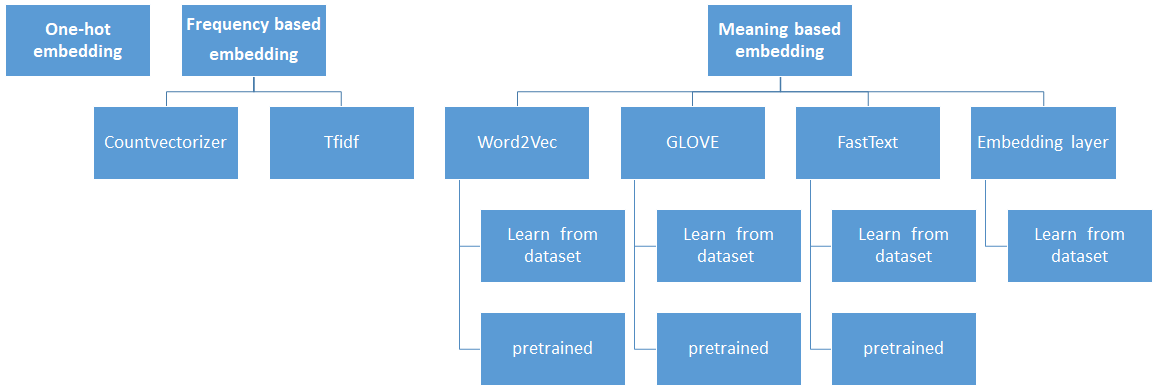

#### https://nlp.stanford.edu/projects/glove/


In [21]:
import transformers
from sentence_transformers import SentenceTransformer

/Users/naveen1.mathur/Desktop/x/sftc/_learning/ml/mlp/ml-projects/_env_04_SENTIMENT_ANALYSIS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [23]:
sentences = ["analysis", "analytics"]
embeddings = model.encode(sentences, truncate_dim=256)

In [24]:
print(embeddings[1])

[ 4.42426128e-04 -2.67839897e-03 -1.21396393e-01  5.50731048e-02
  2.44113058e-02  7.12781027e-03  1.06301799e-01  1.07934270e-02
  3.12141590e-02  2.52740756e-02 -7.32876593e-03 -6.14363328e-03
  5.39900623e-02  2.39978712e-02 -7.74326101e-02  2.35557500e-02
  2.51668133e-02 -1.96987819e-02 -8.90109017e-02 -1.33211002e-01
 -9.57247689e-02 -2.99107023e-02  1.14995325e-02 -1.52080758e-02
  4.25480418e-02  2.59835385e-02 -4.92246114e-02  2.80392971e-02
 -1.07759591e-02 -9.09567252e-02 -3.36027294e-02  4.16831188e-02
  4.59262058e-02  4.30101566e-02 -1.18869454e-01 -4.99327034e-02
 -1.70697726e-03  2.27496289e-02  5.66493236e-02 -2.36215442e-02
 -7.85092339e-02 -3.66949849e-02  2.46855002e-02  4.43073809e-02
  8.64653010e-03 -4.34272643e-03 -5.75240962e-02  1.38068637e-02
 -3.65442559e-02  9.31437910e-02 -9.28350240e-02 -6.04986632e-03
 -4.69845496e-02  8.59004096e-04  6.37143999e-02  3.30860242e-02
 -6.27896115e-02 -7.10701942e-02 -7.96104968e-03  3.63842584e-02
  1.85647160e-02 -5.09741

In [25]:
print(embeddings[0])

[-2.47794706e-02  1.06600575e-01 -9.21595562e-03  2.59898119e-02
  2.43012737e-02  6.00674264e-02  1.21322945e-01  1.04754157e-02
  2.42955778e-02 -6.24484988e-03  2.61379145e-02  3.31644691e-03
  1.05845658e-02  4.21719998e-02 -6.84271678e-02 -5.33345863e-02
 -2.30662264e-02 -7.71192387e-02 -6.40936345e-02 -9.33228806e-02
 -6.03700094e-02 -1.76499188e-02 -3.57985566e-03  3.11765764e-02
 -6.20838962e-02  4.52120826e-02 -8.79271794e-03  4.10643555e-02
  5.93479462e-02 -5.73632792e-02  5.29178884e-03  2.06900053e-02
  1.05506450e-01  1.36240898e-03 -3.90998907e-02  3.81299481e-02
  2.83996854e-02  5.48750497e-02  4.01949361e-02 -8.00662616e-04
 -1.03962235e-01 -5.10799624e-02  1.74484327e-02  1.54943177e-02
 -8.15777667e-03 -4.90732603e-02 -2.50758193e-02 -7.37218070e-04
 -5.86415082e-02 -9.34640062e-04 -9.37773064e-02  3.58232036e-02
 -4.18707170e-02 -6.76025227e-02  2.26738714e-02  2.01921836e-02
 -2.64977515e-02 -6.46391660e-02  2.73014791e-02 -4.47301865e-02
  1.05915457e-01  1.62368

In [26]:
truncate_dimension = 512
trainDataEmbeddings = model.encode(trainData.X.values, truncate_dim=truncate_dimension)
testDataEmbeddings = model.encode(testData.X.values,truncate_dim=truncate_dimension)

In [27]:
trainDataEmbeddings

array([[-0.03023622, -0.01638035,  0.05650844, ..., -0.08903001,
        -0.0186766 ,  0.01298011],
       [-0.05754432, -0.01425981, -0.01090349, ..., -0.01395191,
        -0.00199279,  0.03913176],
       [-0.00520335, -0.12808992,  0.00300854, ..., -0.10959245,
        -0.04621904,  0.05808084],
       ...,
       [-0.03644965, -0.09113055,  0.00557136, ...,  0.00345933,
        -0.07428187, -0.05459164],
       [-0.11255559, -0.04520923, -0.04372989, ..., -0.02943627,
         0.02984567, -0.03127494],
       [-0.04854826, -0.05845277, -0.03698842, ...,  0.01707738,
         0.06906448, -0.12362056]], dtype=float32)

In [28]:
trainLabelsDataEmbeddings = trainData.y.map( {'positive': 1, 'negative': 0} )
testLabelsDataEmbeddings = testData.y.map( {'positive': 1, 'negative': 0} )

In [29]:
trainLabelsDataEmbeddings

34129    1
9393     0
19705    1
18318    1
15029    1
        ..
15009    1
11173    1
49421    0
49677    1
38456    0
Name: sentiment, Length: 750, dtype: int64

In [30]:
from sklearn import linear_model

In [31]:
logisticRegressionModel = linear_model.LinearRegression()
logisticRegressionModel.fit(trainDataEmbeddings, trainLabelsDataEmbeddings)

LinearRegression()

In [32]:
y_preds = logisticRegressionModel.predict(testDataEmbeddings)

In [33]:
y_preds

array([ 0.9233736 ,  0.05817711,  0.5922215 ,  0.6205492 , -0.12103254,
        0.8405889 ,  0.56850207,  0.7392961 ,  0.57711273,  0.03185117,
        1.5534537 ,  0.45630068,  0.84308016,  1.1487162 ,  0.08956188,
        0.28719002,  0.06151575,  0.94968534, -0.62067175,  1.4452394 ,
        0.89057046,  0.05628693, -0.21592939,  1.0280865 ,  0.24802941,
        0.6786978 ,  1.5904233 , -0.20428729,  1.1335784 , -0.06333637,
        1.3798734 ,  0.35815126,  0.39992166,  0.950968  , -0.01893866,
        0.25005507, -0.6076677 ,  0.6505565 ,  0.8035354 ,  0.38462466,
        0.49749887,  0.7699418 ,  0.41789943,  1.0624156 ,  0.53524923,
        0.48637933,  0.46622622,  1.1178416 ,  0.15254712,  0.28828263,
        0.8436527 ,  0.16662967,  0.61901295,  0.860125  ,  0.80754316,
        1.2922199 ,  0.45474905,  1.1129657 , -0.34785366,  1.0609362 ,
       -0.0940094 , -0.42701447,  0.31907558,  0.64739704,  1.4667915 ,
        0.27336496, -0.0051775 ,  1.0022252 ,  0.8940611 ,  0.98

In [34]:
for i in range(0, len(y_preds)):
    y_preds[i] = 1 if y_preds[i] >= 0.5 else 0
y_preds

array([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1.

In [35]:
from sklearn import metrics

In [36]:
print(f"classification report: \n{metrics.classification_report(testLabelsDataEmbeddings, y_preds)}")

classification report: 
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       128
           1       0.66      0.72      0.69       122

    accuracy                           0.68       250
   macro avg       0.69      0.68      0.68       250
weighted avg       0.69      0.68      0.68       250

